In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from operator import or_
from toolz import reduce
from tqdm.auto import tqdm
from aging.plotting import format_plots, figure, add_identity, save_factory, PLOT_CONFIG
from datetime import timedelta

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, accuracy_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "longv1-linear-model-death-pred", tight_layout=False)

In [3]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [4]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

def load_male_long_df(average_weeks=False, merge_size=True, merge_ages=False):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )

    df = df[keep_syllables]
    
    masks = [df.index.get_level_values("age") > 100]
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()
    
    if merge_size:
        size_df = pd.read_parquet(
            "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
        )
        df = df.join(size_df[["quant_0.5"]])
        
        df.loc[df["quant_0.5"] == 0, "quant_0.5"] = np.nan
        
        if df['quant_0.5'].isna().sum() > 0:
            df["quant_0.5"] = (
                df["quant_0.5"].groupby("mouse")
                .transform(lambda df: df.sort_index(level="age").interpolate())
            )

    if average_weeks:
        rsdf = df.reset_index()
        start_date = rsdf['date'].min()
        end_date = rsdf['date'].max() + timedelta(days=1)

        dt = pd.date_range(start_date, end_date, freq='D')

        date_df = pd.DataFrame(dict(dow=dt.day_of_week), index=dt.date)
        cycle = date_df.diff()['dow'] < 0
        date_df['week'] = (cycle.cumsum().rename('week') // 2) * 2

        long_df_dates = pd.Series(df.index.get_level_values('date'), index=df.index, name='week')
        df['week'] = long_df_dates.map(lambda x: date_df.loc[x.date(), 'week'])

        if merge_ages:
            df = df.reset_index(level='age')
            df['age'] = df.groupby('week')['week'].transform(lambda x: x + 3)
            df = df.set_index(['age', 'week'], append=True)
        else:
            df = df.set_index('week', append=True)

        new_df = []
        for (mouse, week), _df in df.groupby(['mouse', 'week'], observed=True):
            _df = _df.reset_index(level='age')
            if len(_df) > 2:
                _df = _df.iloc[:2]
            if len(_df) == 1:
                new_df.append(_df.iloc[[0]])
            else:
                _tmp_df = pd.DataFrame(_df.mean()).T
                _tmp_df.index = _df.index[[0]]
                new_df.append(_tmp_df)

        new_df = pd.concat(new_df).set_index('age', append=True)
        
        if merge_size:
            age_cut = pd.cut(new_df.index.get_level_values("age"), 21)
            new_df["quant_0.5"] = new_df.groupby(age_cut, observed=True)["quant_0.5"].transform(zscore)
            new_df["quant_0.5"] = new_df["quant_0.5"].fillna(0)

        return new_df

    if merge_size:
        age_cut = pd.cut(df.index.get_level_values("age"), 21)
        df["quant_0.5"] = df.groupby(age_cut, observed=True)["quant_0.5"].transform(zscore)
        df["quant_0.5"] = df["quant_0.5"].fillna(0)

    return df


def load_long_df2(average_weeks=True):
    df = load_male_long_df(average_weeks=average_weeks, merge_ages=False)
    
    age = df.index.get_level_values("age")

    sizes_col = df['quant_0.5']
    df = df.drop(columns=['quant_0.5'])

    return df, sizes_col, age


In [5]:
tmp_df, size_col, age = load_long_df2(True)

In [6]:
pipeline = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=6),
)

In [7]:
pred_age = cross_val_predict(
    pipeline,
    tmp_df.astype(float),
    age,
    cv=KFold(n_splits=10, shuffle=True, random_state=0),
    n_jobs=-1
)
r2_score(age, pred_age)

0.8178248347546849

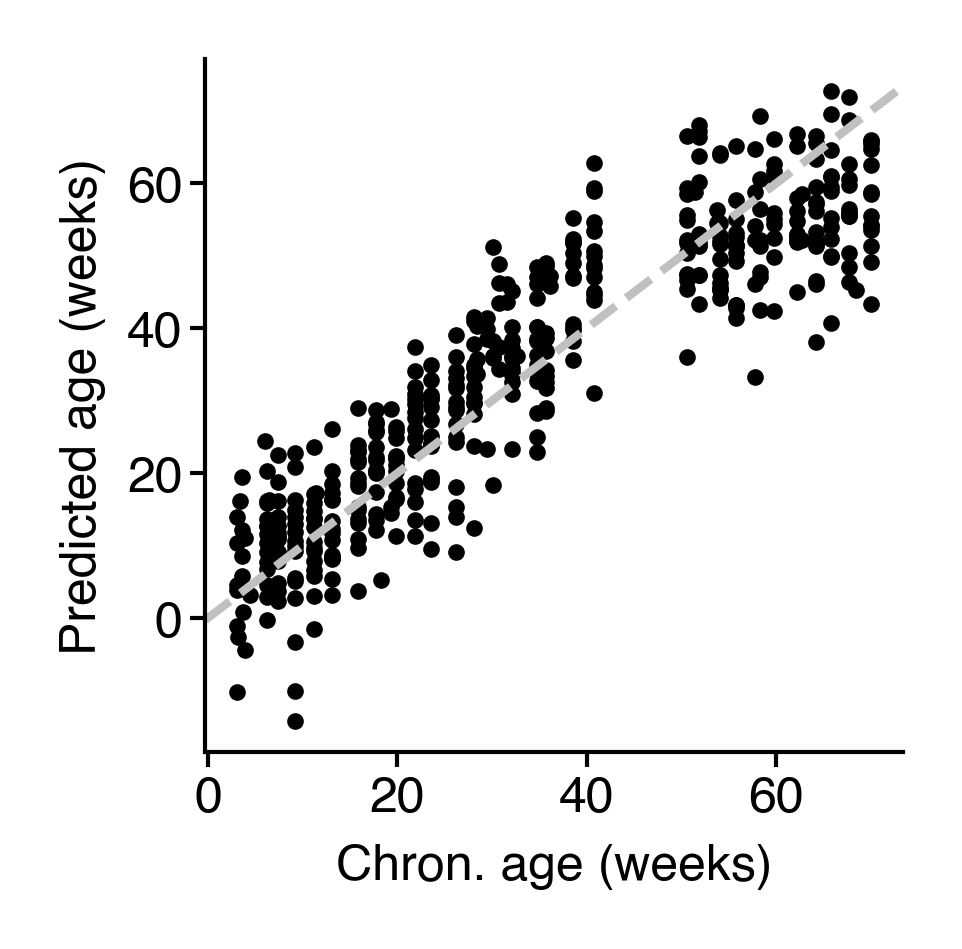

In [8]:
fig = figure(1.5, 1.5)
ax = fig.gca()
ax.scatter(age, pred_age, s=4, color='k', lw=0)
ax.set(xlabel="Chron. age (weeks)", ylabel="Predicted age (weeks)")
add_identity(ax, color='silver', ls='--')
sns.despine()

In [9]:
pipeline.fit(tmp_df.astype(float), age)
pred_age = pipeline.predict(tmp_df.astype(float))
tmp_df['bio_age'] = pred_age

## Try to predict death

In [10]:
def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["bio_age"]],
        df["classes"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds

In [11]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(56, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [12]:
accs = []
for seed in tqdm(range(100)):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 -0.19


In [13]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = subset_join.copy()
    shuff_df['bio_age'] = shuff_df['bio_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 -0.11


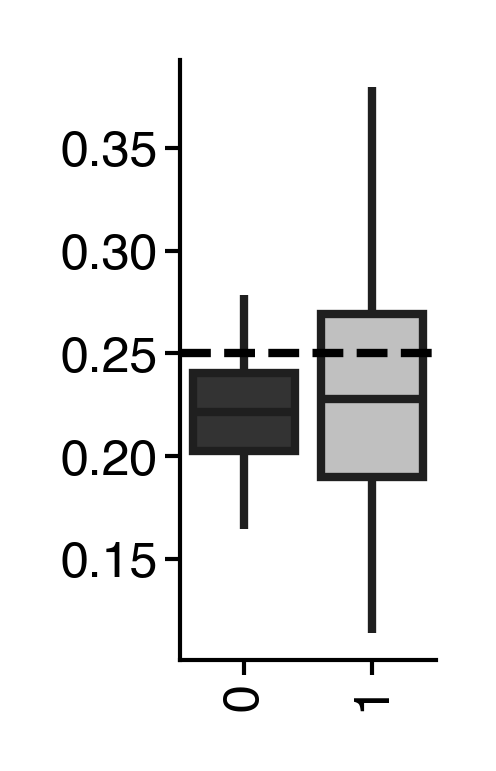

In [14]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
# ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "death-rank-classifier-via-bambi");

### Correlate bio age with time of death

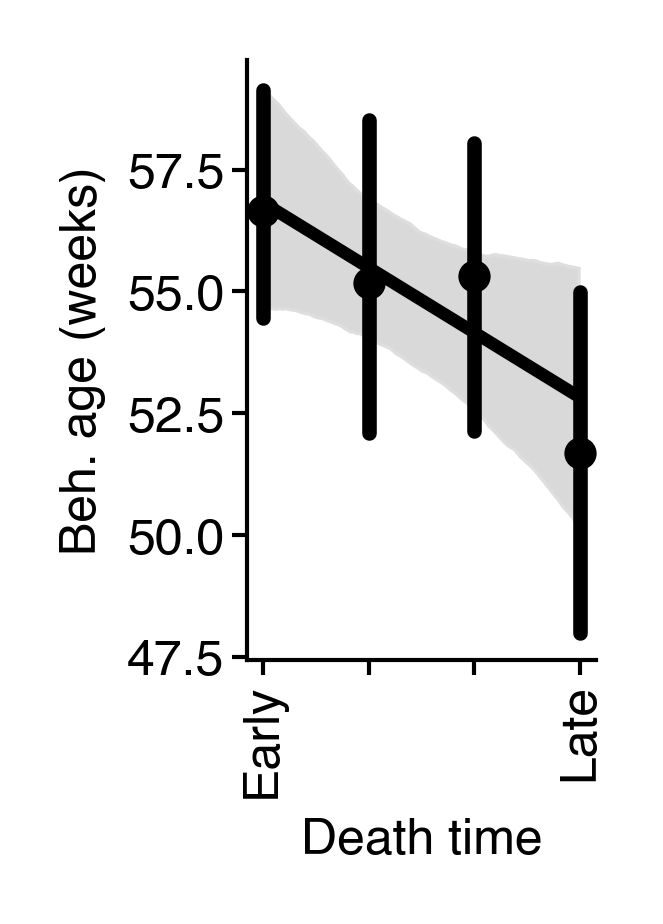

In [15]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset_join, x='classes', y='bio_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "lr-beh-age-vs-death");

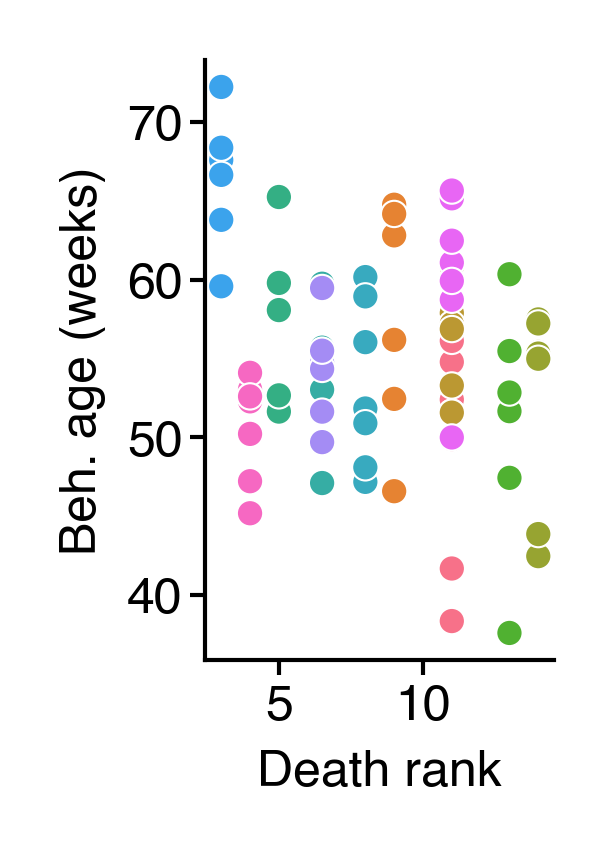

In [42]:
fig = figure(0.75, 1.3)
# ax = sns.regplot(data=subset_join, x='death_rank', y='bio_age', scatter=False)
ax = sns.scatterplot(data=subset_join, x='death_rank', y='bio_age', hue='mouse', legend=False, s=10)
ax.set(ylabel="Beh. age (weeks)", xlabel="Death rank")
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

In [17]:
subset_join[['death_rank', 'bio_age']].corr(method='spearman')

,death_rank,bio_age
death_rank,1.000000,-0.185772
bio_age,-0.185772,1.000000


In [18]:
subset_join[['classes', 'bio_age']].corr(method='spearman')

,classes,bio_age
classes,1.000000,-0.135994
bio_age,-0.135994,1.000000


In [19]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(20, 37)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [20]:
accs = []
for seed in tqdm(range(100)):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 0.42


In [21]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = subset_join.copy()
    shuff_df['bio_age'] = shuff_df['bio_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 -0.02


/tmp/ipykernel_31108/543429212.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
webf NOT subset; don't know how to subset; dropped


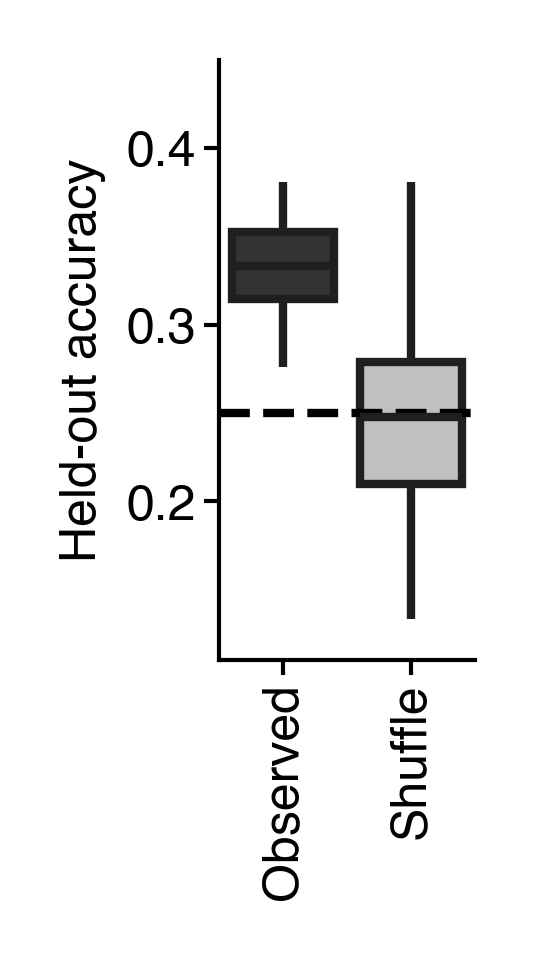

In [22]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "mid-age-1-death-rank-classifier-via-bambi");

In [23]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(37, 56)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [24]:
accs = []
for seed in tqdm(range(100)):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 0.25


In [25]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = subset_join.copy()
    shuff_df['bio_age'] = shuff_df['bio_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 0.03


/tmp/ipykernel_31108/475407916.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
webf NOT subset; don't know how to subset; dropped


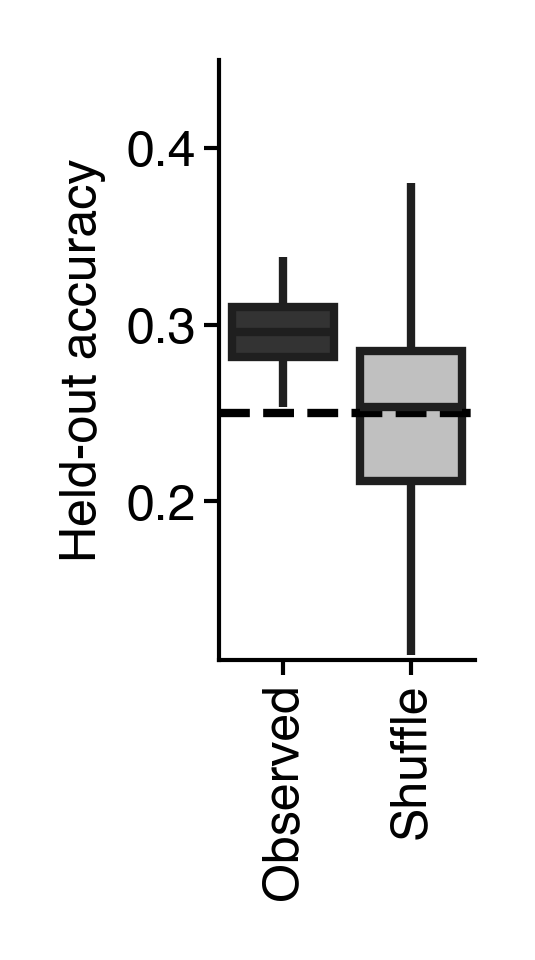

In [26]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "mid-age-2-death-rank-classifier-via-bambi");

In [27]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(0, 20)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [28]:
accs = []
for seed in tqdm(range(100)):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 0.3


In [29]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = subset_join.copy()
    shuff_df['bio_age'] = shuff_df['bio_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 0.02


/tmp/ipykernel_31108/3219946401.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
webf NOT subset; don't know how to subset; dropped


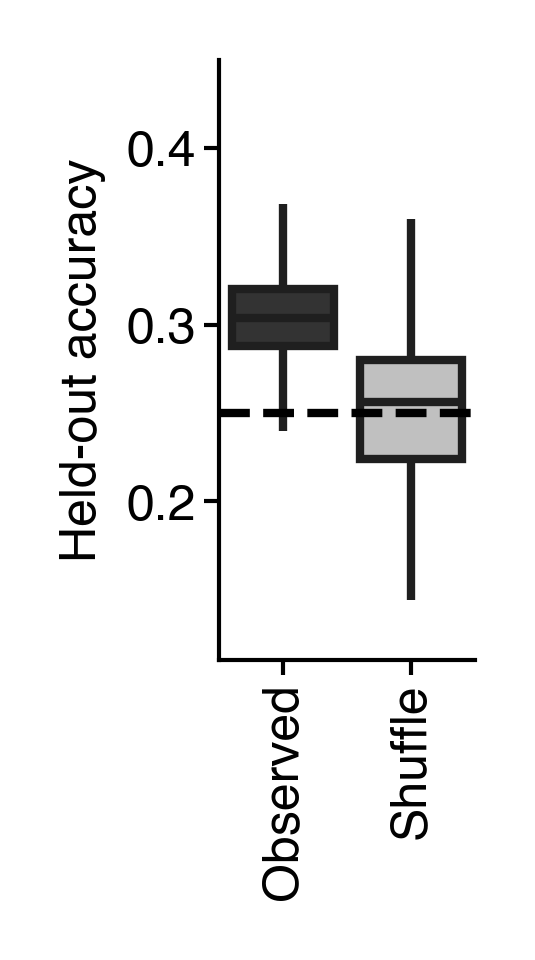

In [30]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "young-age-death-rank-classifier-via-bambi");

## Compute syllable use correlations with death at late life stages

In [31]:
subset = reset_df[reset_df['age'].between(56, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [32]:
subset_join.shape

(79, 70)

In [33]:
subset_join.head()

,mouse,subject_name,session_name,uuid,date,week,age,0,2,4,...,90,93,95,97,98,bio_age,id,Death,death_rank,classes
0,01_01,01_01_207,207,7bfa81df-b55f-4094-ba70-95791afb1e63,2022-04-17 14:45:50,54,58.214287,5.0,68.5,72.5,...,99.5,8.5,25.5,13.5,56.0,56.184992,01_01,2023-12-04,11.0,2
1,01_01,01_01_209,209,279bcc86-ae29-4b82-9c7f-b8238795aa02,2022-05-01 14:21:16,56,59.714287,2.0,62.0,123.0,...,68.0,7.0,46.0,9.0,62.0,54.775471,01_01,2023-12-04,11.0,2
2,01_01,01_01_210,210,afc391f4-02af-4132-ac17-1d69dc06bcb9,2022-05-14 17:48:22,58,62.142860,5.5,54.0,113.0,...,61.0,12.5,31.0,11.0,62.0,52.389324,01_01,2023-12-04,11.0,2
3,01_01,01_01_212,212,4f5cf67f-fd37-44eb-9cdf-71baeff649f6,2022-06-01 11:47:32,60,64.142860,11.0,39.0,75.0,...,43.0,9.0,26.0,13.0,65.0,38.336572,01_01,2023-12-04,11.0,2
4,01_01,01_01_213,213,d6393e2e-a99f-42c4-815b-aab37ac25504,2022-06-12 15:30:03,62,65.714287,3.0,36.0,43.0,...,109.0,9.0,7.0,19.0,50.0,41.671511,01_01,2023-12-04,11.0,2


In [34]:
subset_join.columns = [str(x) for x in subset_join.columns]

In [35]:
syll_cols = [x for x in subset_join.columns if x.isdigit()]

webf NOT subset; don't know how to subset; dropped


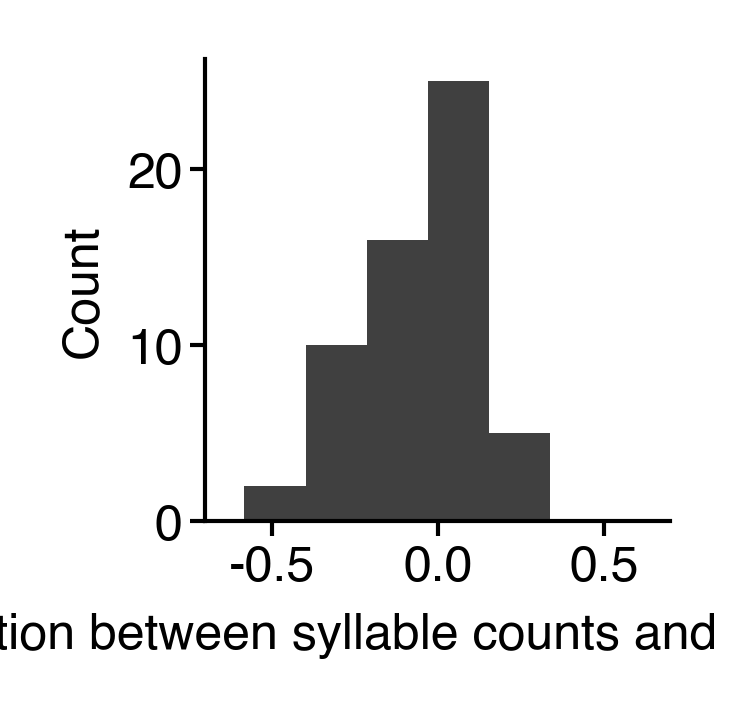

In [36]:
fig = figure(1, 1)
ax = sns.histplot(
    subset_join[syll_cols + ["bio_age"]]
    .corr(method="spearman")
    .loc["bio_age"]
    .drop("bio_age"),
    element="step",
    lw=0,
    color="k",
    bins=5,
)
ax.set(xlabel="Correlation between syllable counts and beh. age (rho)", xlim=(-0.7, 0.7))
sns.despine()
saver(fig, "counts-vs-lm-beh-age-correlation");

In [37]:
lm_corrs = subset_join[syll_cols + ['bio_age']].corr(method='spearman').loc['bio_age'].sort_values().drop('bio_age')

In [38]:
lm_corrs

62   -0.582372
41   -0.410555
36   -0.393599
85   -0.373886
84   -0.332148
68   -0.328359
23   -0.327309
69   -0.284798
93   -0.270316
64   -0.261118
32   -0.242335
5    -0.232092
13   -0.203991
42   -0.196912
24   -0.195203
27   -0.194431
73   -0.185589
60   -0.150137
71   -0.135226
53   -0.117278
0    -0.099245
77   -0.071696
49   -0.068034
30   -0.063564
59   -0.051591
11   -0.045857
9    -0.042479
12   -0.036243
70   -0.029593
67   -0.015227
76   -0.001089
2     0.006975
16    0.014049
74    0.030421
6     0.035043
61    0.037739
33    0.043035
17    0.045858
98    0.055591
10    0.058101
79    0.062001
4     0.080878
54    0.082745
97    0.091283
44    0.092783
95    0.098895
14    0.117362
55    0.120960
66    0.123910
39    0.127590
63    0.134073
25    0.136505
52    0.142529
18    0.230792
50    0.250318
7     0.252695
83    0.290772
90    0.338554
Name: bio_age, dtype: float64

In [39]:
pd.DataFrame(lm_corrs).to_parquet('/n/scratch/users/w/wg41/linear_model_syll_death_corrs.parquet')

In [ ]:
for syll in lm_corrs.index[[0, 1, 31, 32, -2, -1]]:
    fig = figure(0.8, 0.8)
    syll_corr = lm_corrs[syll]
    ax = sns.regplot(
        data=subset_join,
        y=syll,
        x="bio_age",
        scatter_kws=dict(s=10, linewidths=0.3, color="silver", edgecolor="k", alpha=1),
        color="k",
    )
    ax.set(
        title=f"Syllable {syll}; rho={syll_corr:0.2f}",
        xlabel="Beh. age (weeks)",
        ylabel="Syllable counts",
    )
    sns.despine()
    saver(fig, f"syll-{syll}-lm-age-vs-counts")